# Fitting Gravitationally Lensed Supernova Light Curves with GausSN

In [7]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.table as at
import sncosmo

# Import the gausSN, kernel, meanfuncs, lensingmodels, and utils packages
os.chdir('..')
from gaussn import gausSN, kernels, meanfuncs, lensingmodels, utils
os.chdir('./ipynb')

# Use a stylesheet for stylish graphing!
plt.style.use('./stylesheet/GausSN.mplstyle')

## Open and plot the data

In [2]:
# Specify location of data and file of interest
glSN_path = '../data/glSN_forGP_sims/'
files = [glSN_path+fn for fn in os.listdir(glSN_path) if fn.endswith('.csv')]
fn = files[10]

# Give a name (snid) to the object and open the data file
snid = fn.split('/')[-1].split('.')[0]
data = at.Table.read(fn, format='csv')
data.sort(['band', 'image', 'time'])

# We are going to want a scaled version of the flux data, so that the maximum flux value of all the data is 1
# Here we compute the factor by which we'll scale the data
factor = np.max(data['flux']) - np.min(data['flux'])
data['flux'] = data['flux'] / factor
data['fluxerr'] = data['fluxerr'] / factor

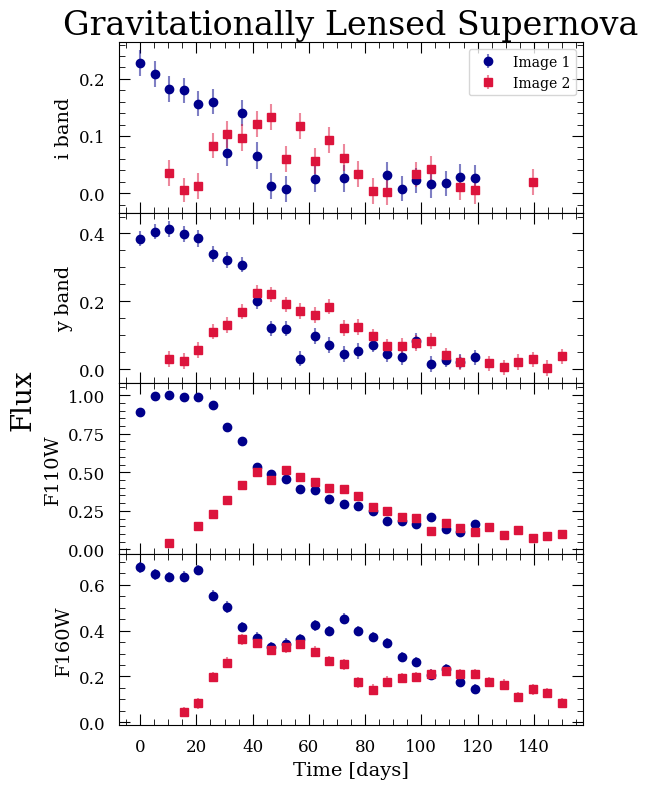

In [3]:
# Plot flux data
fig, ax = utils.plot_object(data)

## Fitting with the GP model using a zero mean function

### Define a few functions that will be helpful for fitting/plotting

In [4]:
# Specify a prior for dynesty's nested sampler
# See the dynesty documenation for more information about how to define a ptform
def ptform(u):
    prior = u
    prior[0] = u[0]                 # A
    prior[1] = (u[1] * 30) + 10     # tau
    prior[2] = (u[2] * 60)          # delta_1,2
    prior[3] = (u[3] * 0.9) + 0.1   # beta_1,2
    return(prior)
    
# Function for kernel and lensing parameter optimization
def fit_lensedSN(data, show_plots=False):

    # Define a GP with a kernel and zero mean function
    meanfunc = meanfuncs.UniformMean([0])
    kernel = kernels.ExpSquaredKernel([0.5, 20])
    lensingmodel = lensingmodels.ConstantMagnification([0, 1])
    gp = gausSN.GP(kernel, meanfunc, lensingmodel)
        
    sampler = gp.optimize_parameters(x = data['time'], y = data['flux'], yerr = data['fluxerr'],
                                     band = data['band'], image = data['image'], fix_mean_params=True,
                                     method='dynesty', ptform=ptform, sampler_kwargs = {'sample': 'unif'})
    
    # If desired, plot the results of the parameter optimization
    if show_plots:
        plt.figure()
        param_names = ['$A$', '$\\tau$', '$\\Delta$', '$\\beta$']
        fig, ax = utils.make_corner(sampler.results, param_names)
        fig.show()
        fig, ax = utils.make_traceplot(sampler.results, param_names)
        fig.show()
    
    # Return the sampler, so you can save the chains or any other information about the optimization, if desired
    return sampler

5808it [00:54, 106.21it/s, +500 | bound: 17 | nc: 1 | ncall: 30686 | eff(%): 20.897 | loglstar:   -inf < 368.647 <    inf | logz: 357.754 +/-  0.146 | dlogz:  0.001 >  0.509]


<Figure size 640x480 with 0 Axes>

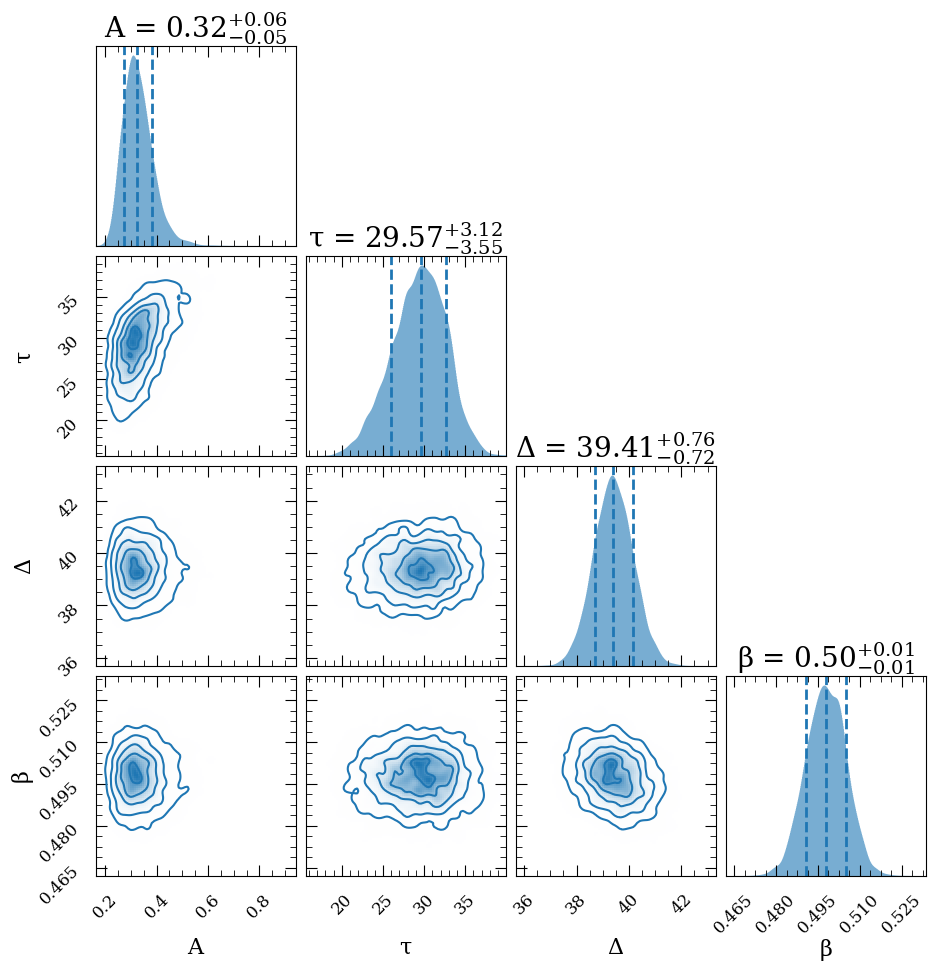

<Figure size 640x480 with 0 Axes>

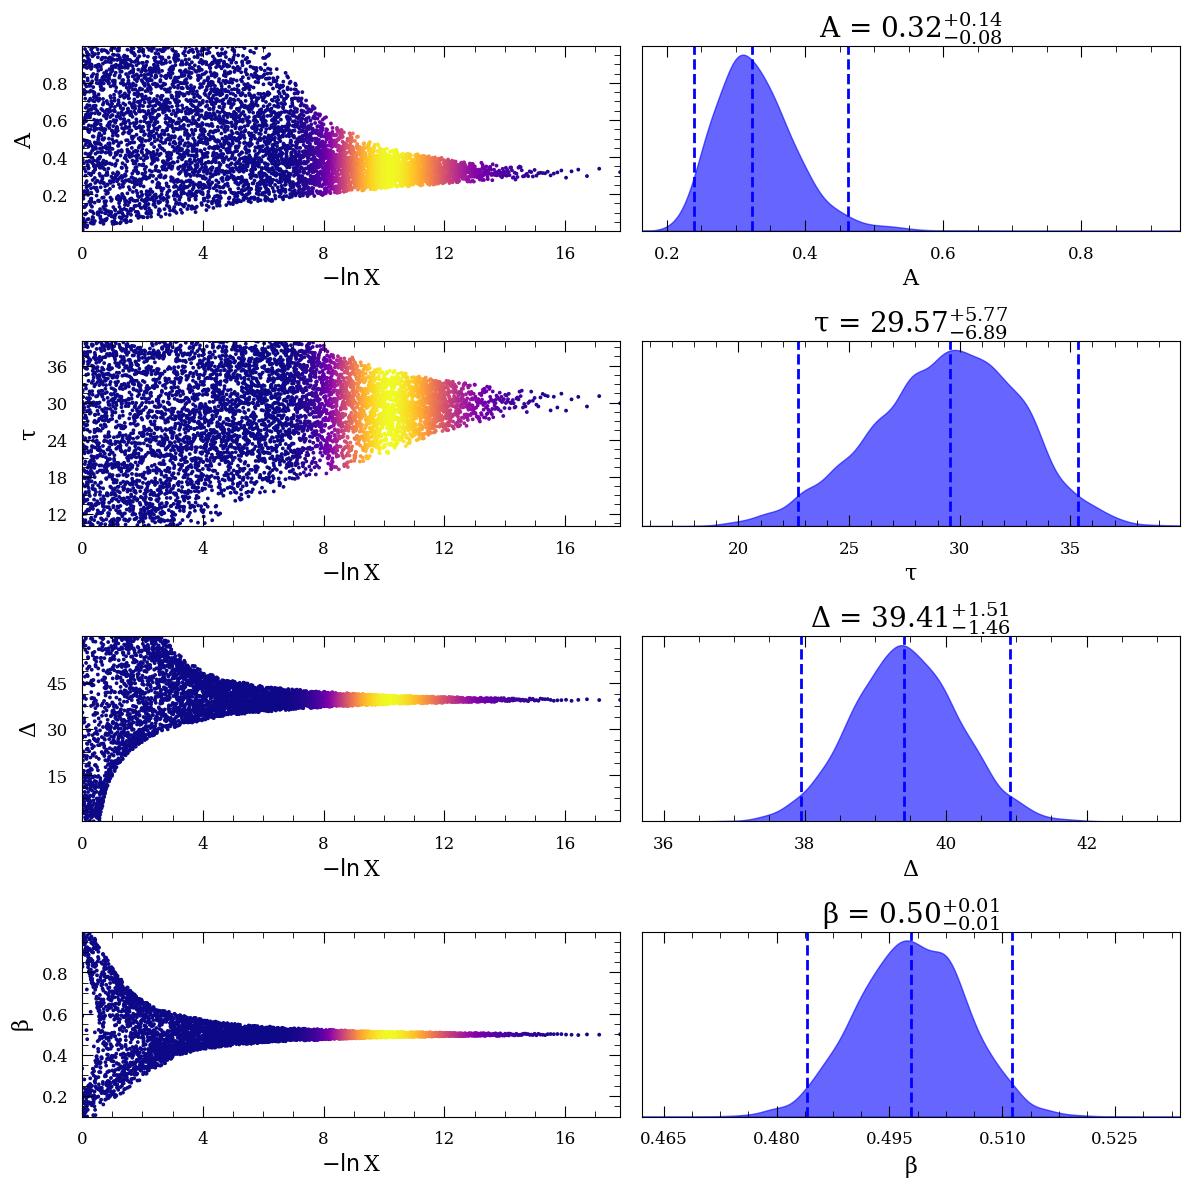

In [5]:
# Fit the light curve
sampler = fit_lensedSN(data, show_plots=True)

### Plot the fitted light curve

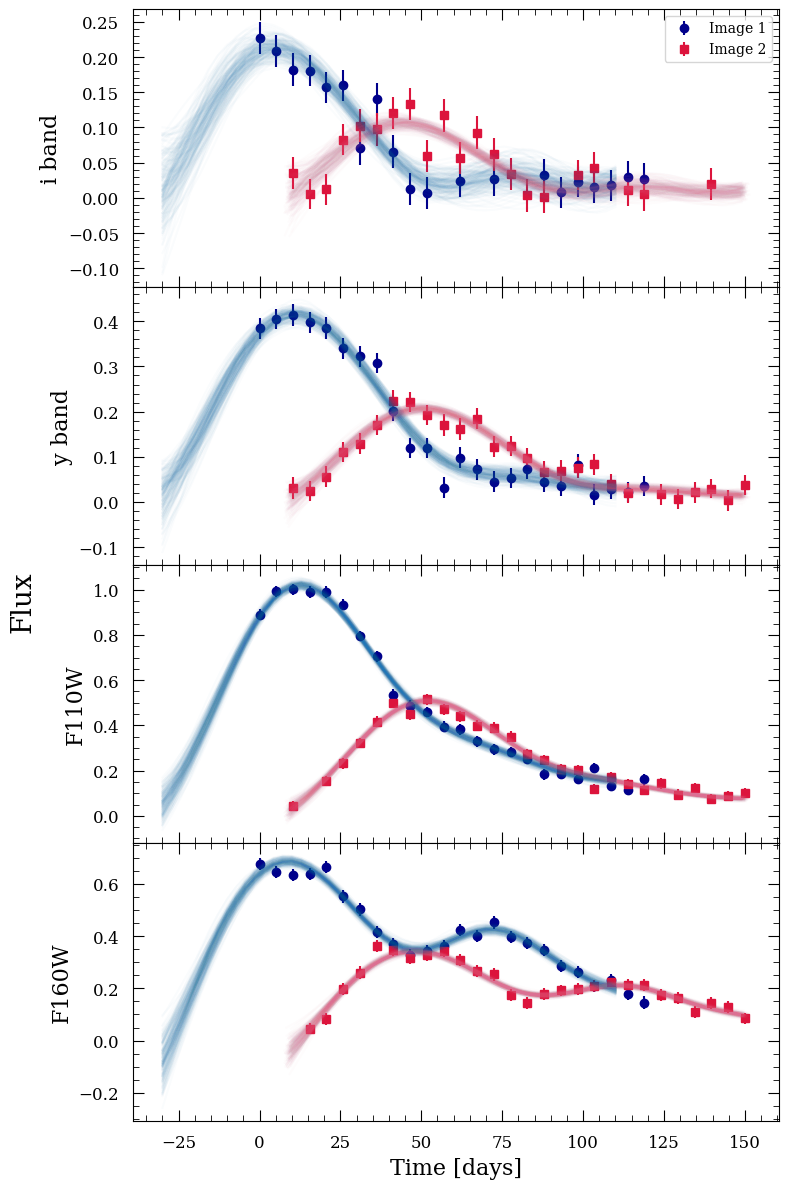

In [6]:
meanfunc = meanfuncs.UniformMean([0])
kernel = kernels.ExpSquaredKernel([0.5, 20])
lensingmodel = lensingmodels.ConstantMagnification([0, 1])

fig, ax = utils.plot_fitted_object(data, sampler.results, kernel, meanfunc, lensingmodel, fix_mean_params=True)

## Fitting with a SN Light Curve Template

### Adjust fitting/plotting functions for use with a SALT template as the mean function

In [8]:
def ptform(u):
    prior = u
    prior[0] = (u[0] * 0.2)                 # A
    prior[1] = (u[1] * 45) + 5              # tau
    prior[2] = (u[2] * 20) - 10             # t0
    prior[3] = (u[3] * 1)                   # x0
    prior[4] = (u[4] * 6) - 3               # x1
    prior[5] = (u[5] * 0.6) - 0.3           # c
    prior[6] = (u[6] * 60)                  # delta_1,2
    prior[7] = (u[7] * 0.9) + 0.1           # beta_1,2
    return(prior)

def fit_lensedSN(data, show_plots=False):

    # Define a GP with a kernel and SALT mean function
    model = sncosmo.Model(source='salt3-nir')
    model.set(z=0.5, t0=0., x0=1.e-8, x1=0., c=0.)

    kernel = kernels.ExpSquaredKernel([0.5, 20])
    meanfunc = meanfuncs.sncosmoMean(model=model, fixed=[True, False, False, False, False])
    lensingmodel = lensingmodels.ConstantMagnification([0, 1])
    gp = gausSN.GP(kernel, meanfunc, lensingmodel)
        
    sampler = gp.optimize_parameters(x = data['time'], y = data['flux'], yerr = data['fluxerr'], band = data['band'], image = data['image'],
                                     method='dynesty', ptform=ptform, sampler_kwargs = {'sample': 'rslice'})
    
    # If desired, plot the results of the parameter optimization
    if show_plots:
        plt.figure()
        param_names = ['$A$', '$\\tau$', '$t_{0}$', '$x_{0}$', '$x_{1}$', '$c$', '$\\Delta_{1,2}$', '$\\beta_{1,2}$']
        fig, ax = utils.make_corner(sampler.results, param_names)
        fig.show()
        fig, ax = utils.make_traceplot(sampler.results, param_names)
        fig.show()
    
    return sampler

/home/eeh55/.conda/envs/glsnEnv/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:3463: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "
9490it [21:39,  7.30it/s, +500 | bound: 43 | nc: 1 | ncall: 483544 | eff(%):  2.068 | loglstar:   -inf < 374.159 <    inf | logz: 355.741 +/-  0.198 | dlogz:  0.001 >  0.509]


<Figure size 640x480 with 0 Axes>

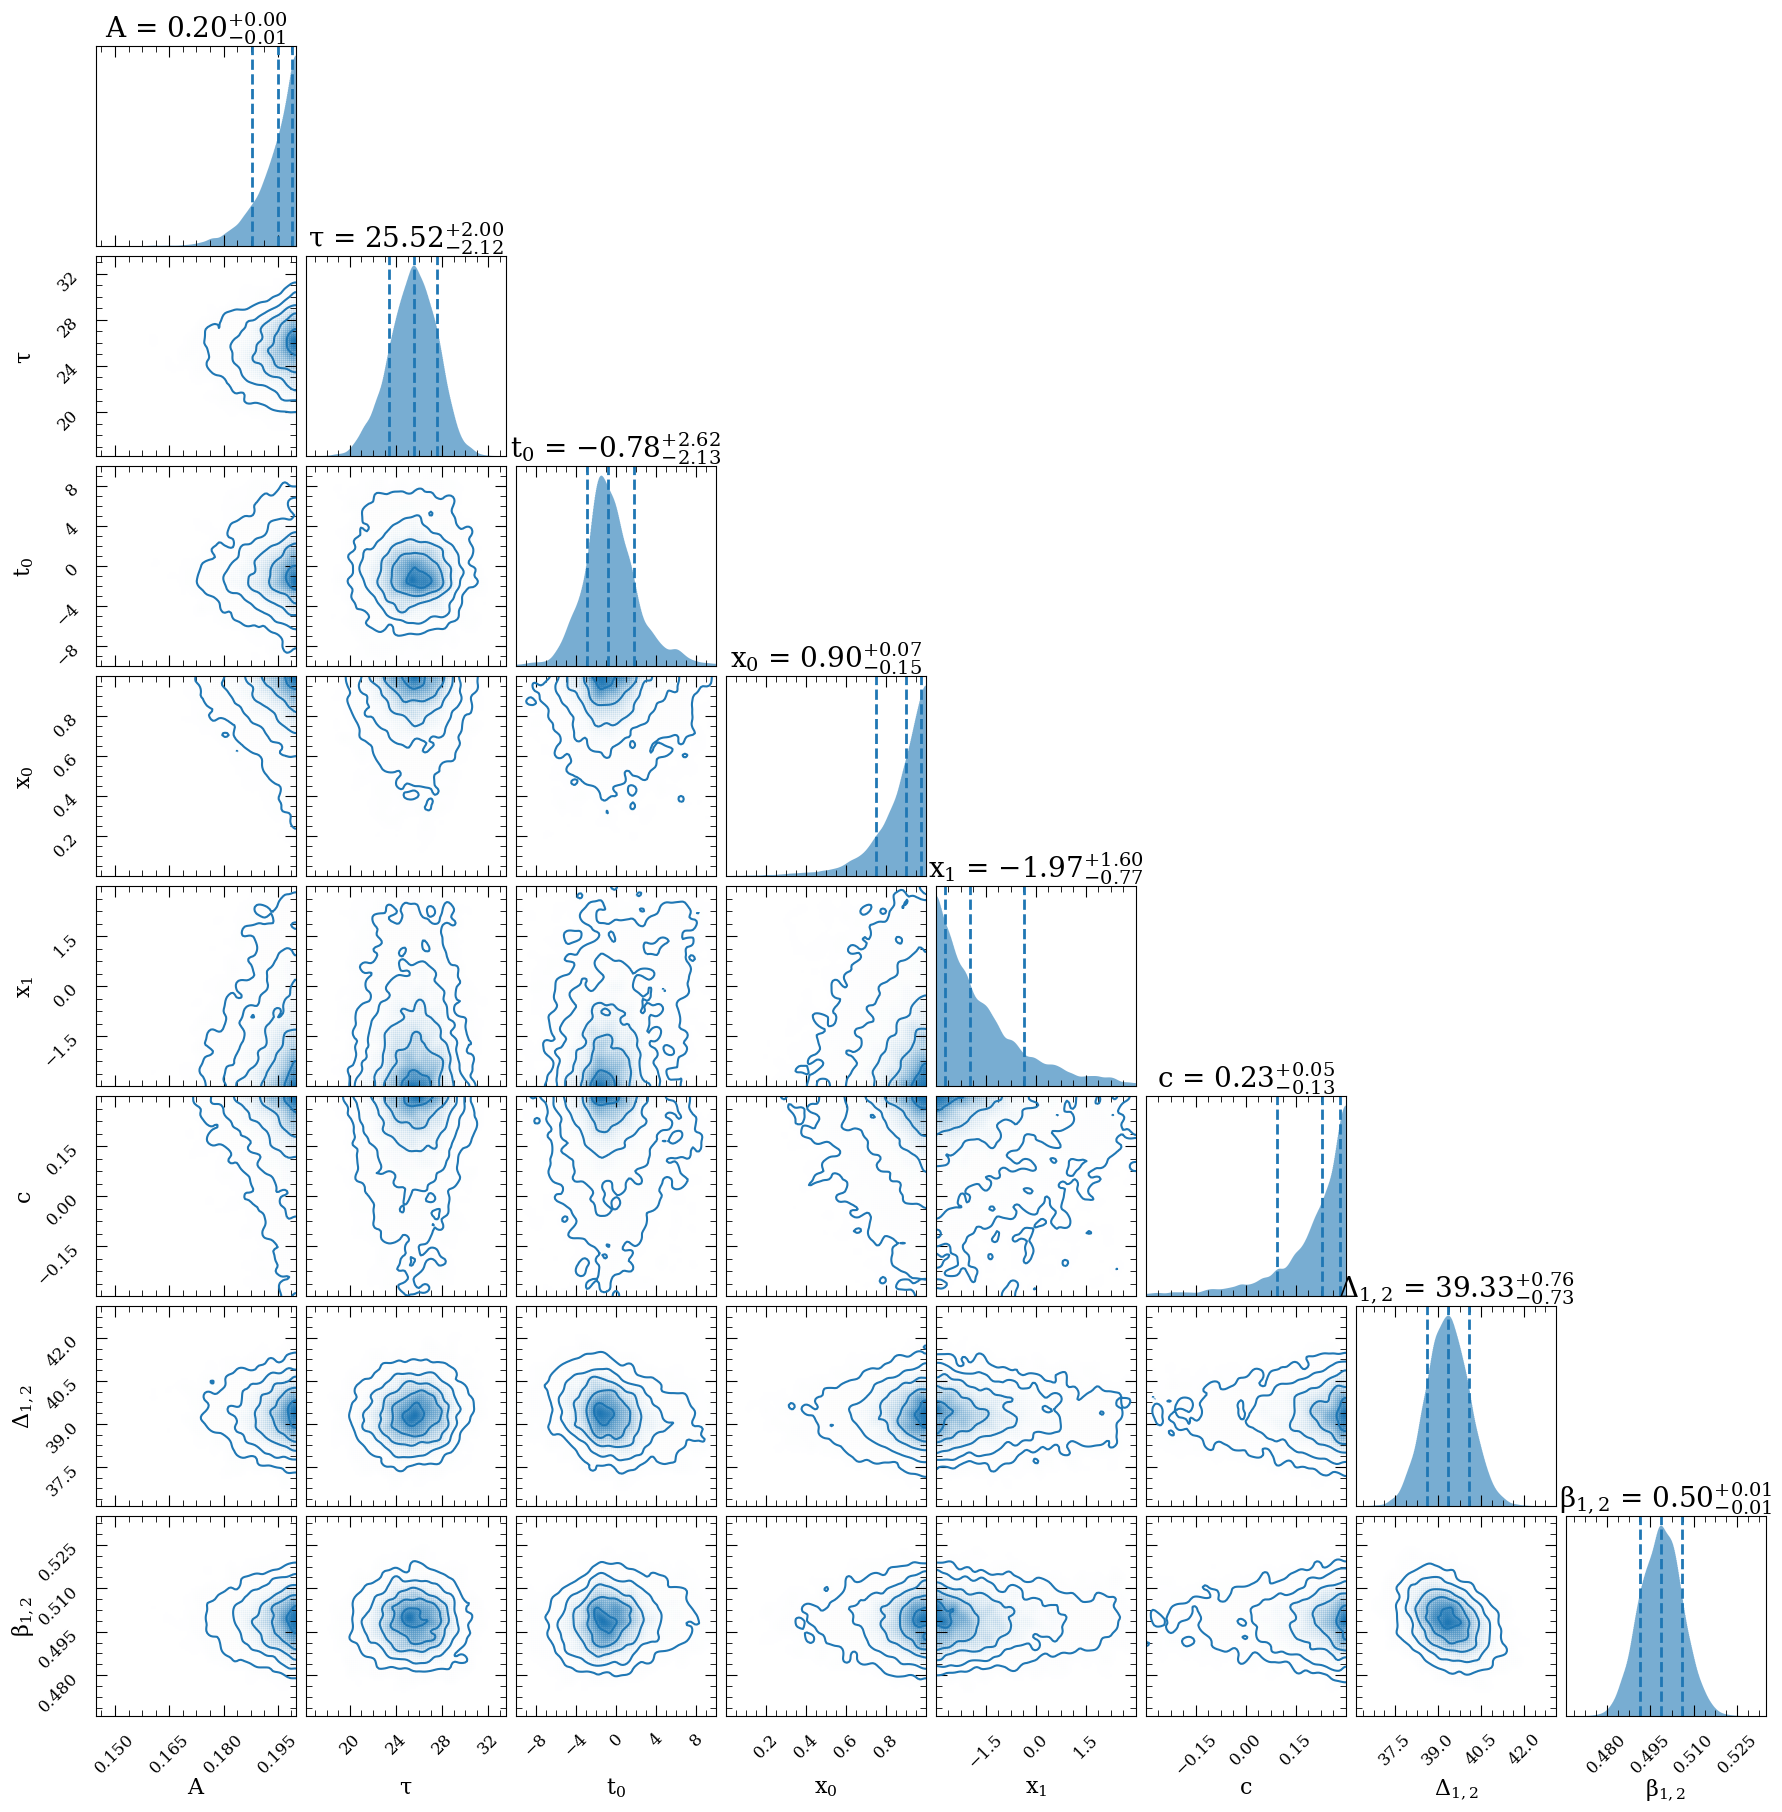

<Figure size 640x480 with 0 Axes>

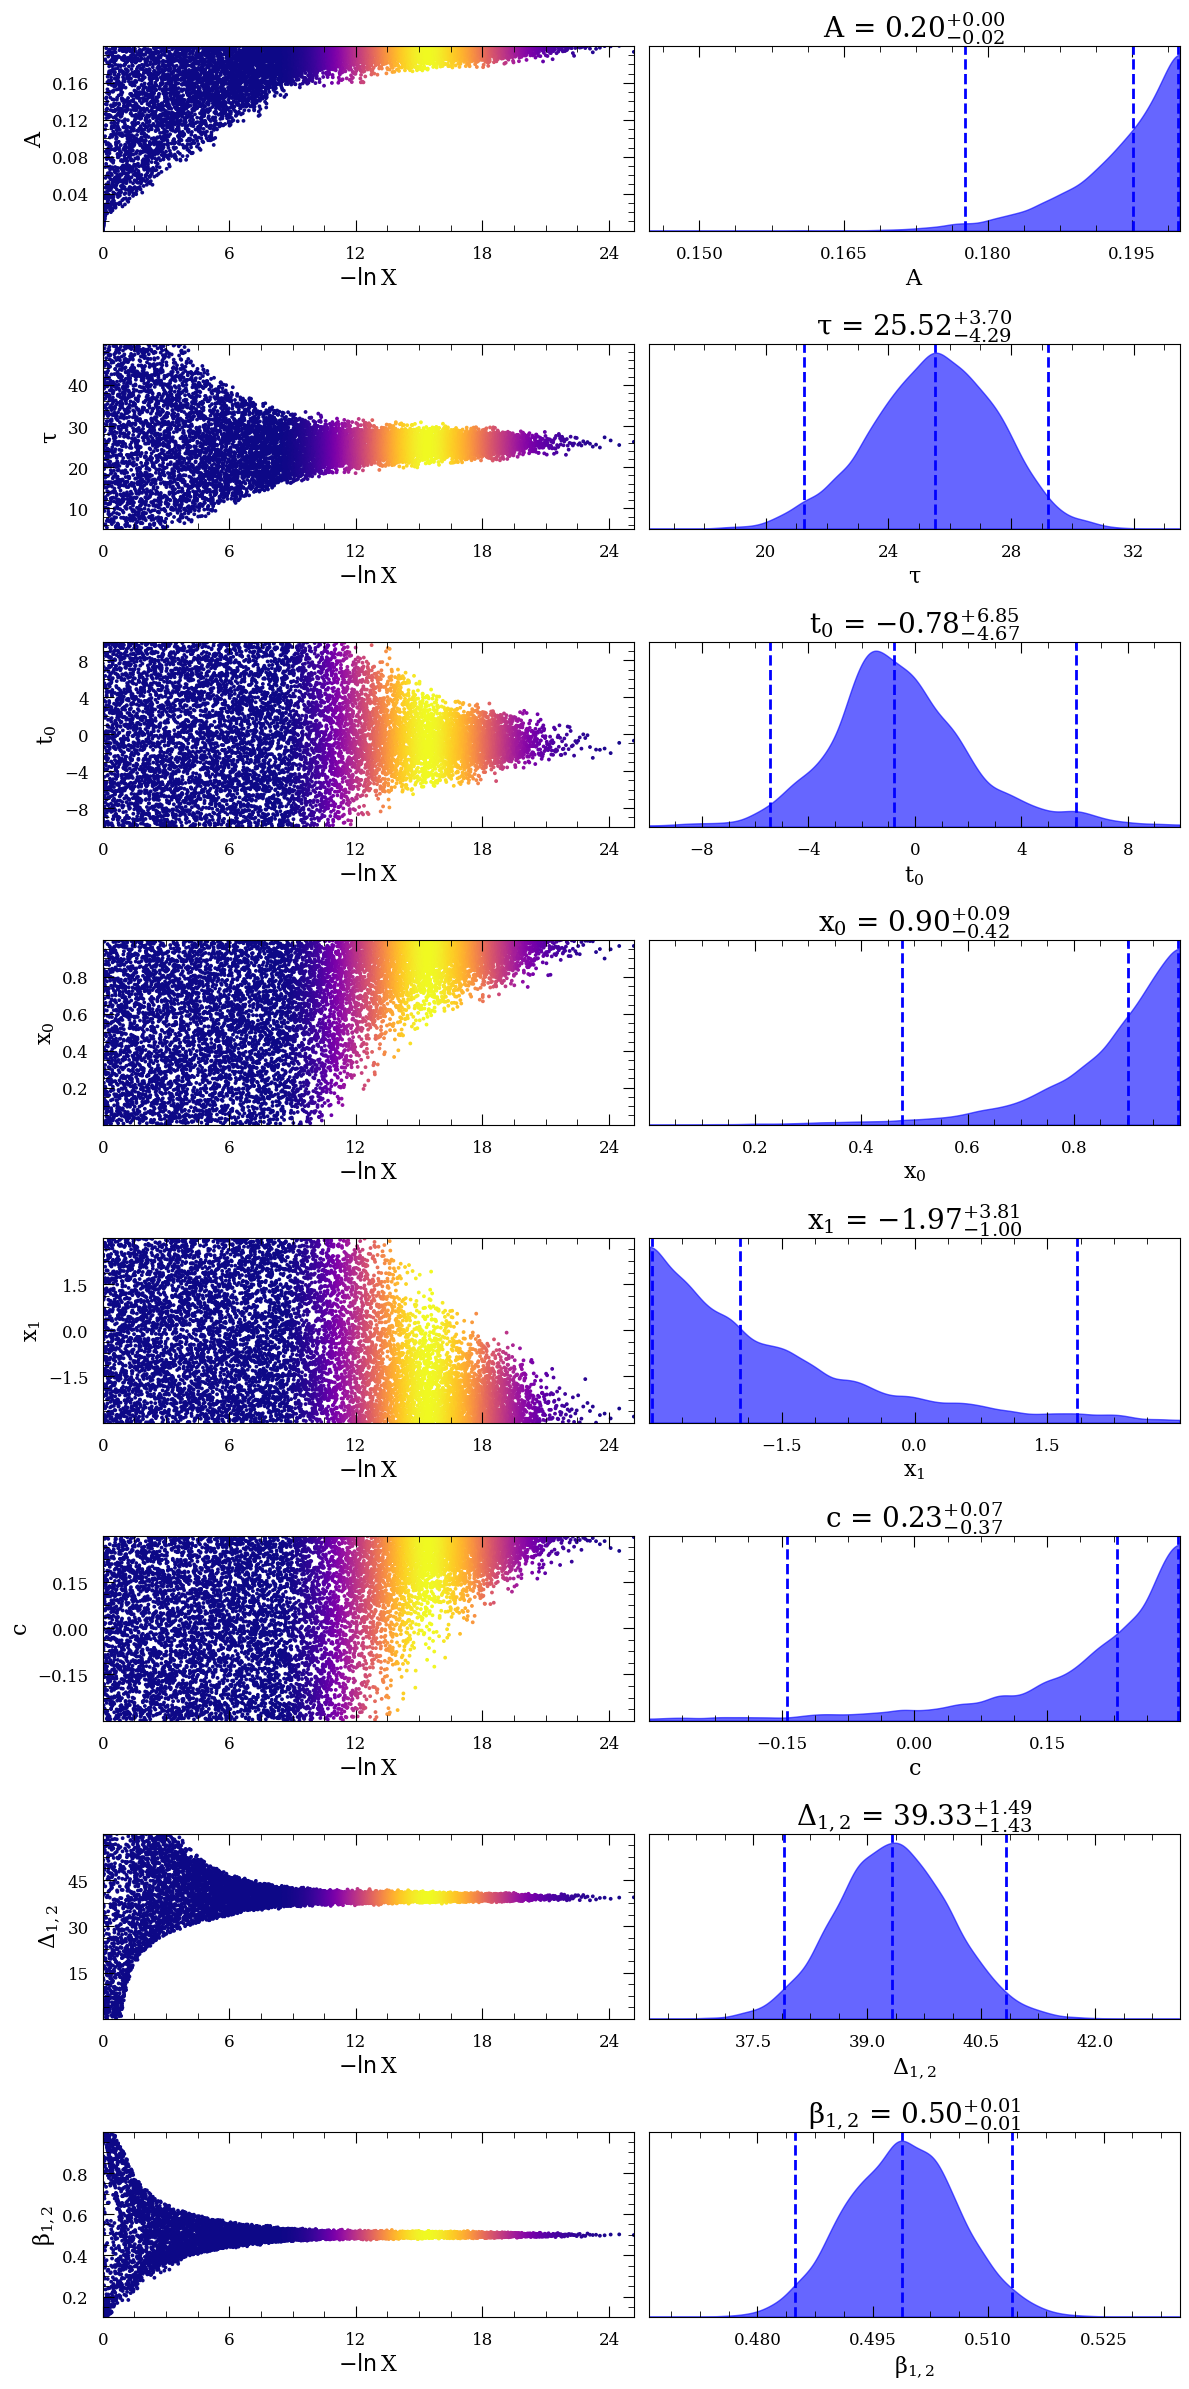

In [9]:
sampler = fit_lensedSN(data, show_plots=True)

/home/eeh55/.conda/envs/glsnEnv/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:3463: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "
/home/eeh55/.conda/envs/glsnEnv/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:3463: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


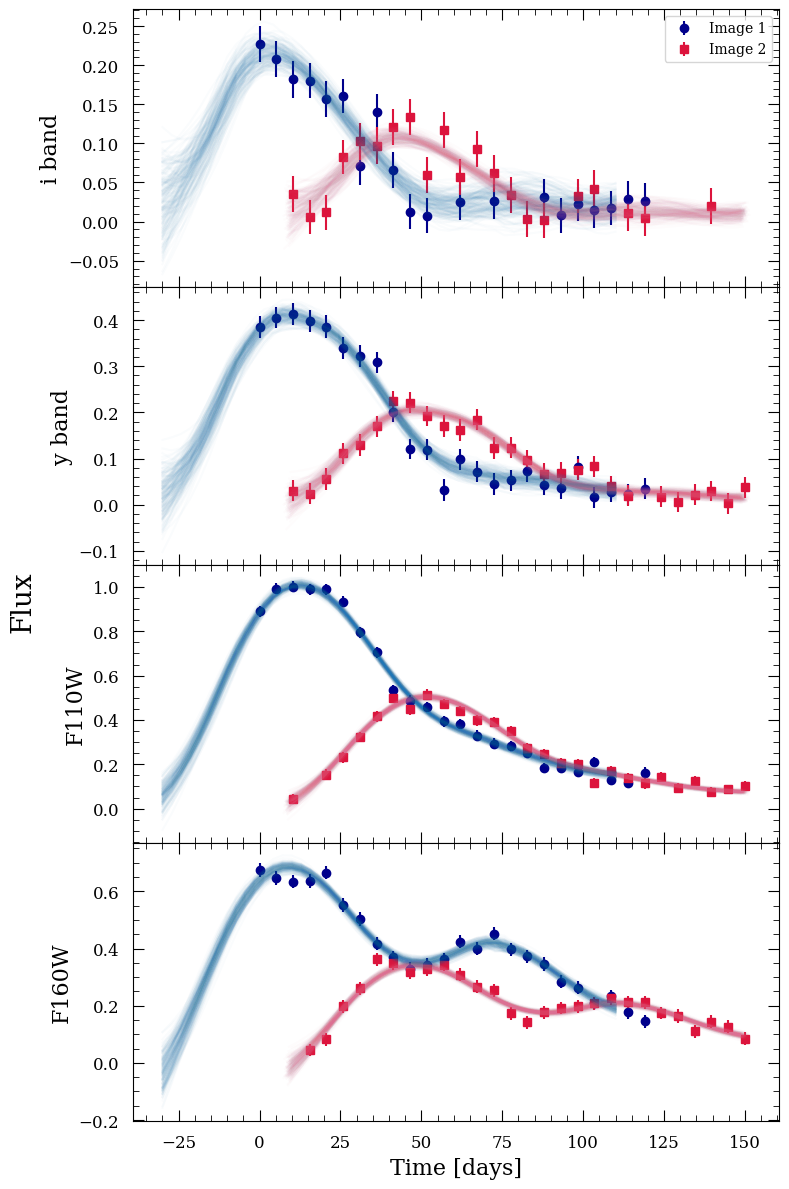

In [10]:
model = sncosmo.Model(source='salt3-nir')
model.set(z=0.5, t0=0., x0=1.e-8, x1=0., c=0.)

kernel = kernels.ExpSquaredKernel([0.5, 20])
meanfunc = meanfuncs.sncosmoMean(model=model, fixed=[True, False, False, False, False])
lensingmodel = lensingmodels.ConstantMagnification([0, 1])

fig, ax = utils.plot_fitted_object(data, sampler.results, kernel, meanfunc, lensingmodel)